In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd

In [4]:
# physical paarameters
lambda_x_ray = 1.54055                  # x-raywavelength
h_beamwidth   = 0.5                       # beamwidth: Use value of s1hg (mm)
l_waferlength = 25                        # sample length in beam direction (mm)
d_film      = 0.000007                  # approx. thickness of lipid film: 7 microns
abs_coeff   = 783                       # absorption coefficient of lipid film (m^-1)
peakwidth   = 40                        # half width of interval for peak search (points)

In [5]:
# +++++ READING IN DATA +++++

RH_data_dict = {}
# iterate through the RH values (hope those are the correct ones):
for RH in range(56, 89, 2):
    RH_data = np.loadtxt(f"data/RH_data/RH{RH}.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
    RH_data_dict[f"RH{RH}"] = {}
    # each dictionary entry includes another dictionary with th "angle", "q_z", and reflectivity "R" as entries
    RH_data_dict[f"RH{RH}"]["angle"] = RH_data[1:,0]
    RH_data_dict[f"RH{RH}"]["q_z"] = 4*np.pi / lambda_x_ray * np.sin(RH_data[1:,0] / 360 * 2 * np.pi)
    RH_data_dict[f"RH{RH}"]["R"] = RH_data[1:,1]



# +++++ APPLY CORRECTIONS +++++

# apply illumination correction
q_z_c = 4*np.pi / lambda_x_ray * h_beamwidth / l_waferlength                                                 # critical value q_z_c > q_z where the illumination correction has to be applied

# iterate through the RH values
for key in RH_data_dict:
    R_array = RH_data_dict[key]["R"]                    # RH specific R array
    R_corr_array = np.zeros_like(R_array)               # additional array for the corrected reflectivities
    q_z_array = RH_data_dict[key]["q_z"]                # RH specific q_z array
    len_R_array = len(R_array)                          # length of the arrays in the RH value dict
    # iterate through the array indices (leaving out index 0 due to 0 division, not affected by illumination correction anyway)
    for i in range(len_R_array):
        q_z = q_z_array[i]
        # illumination correction: check for "incomplete" reflection
        if q_z < q_z_c:
            R_corr_array[i] = R_array[i] * q_z_c / q_z                   # multiply with the correction factor (> 1)
        else:
            R_corr_array[i] = R_array[i]
    
    # add corrected reflectivity to the correct dictionary entry
    RH_data_dict[key]["R_corr"] = R_corr_array


# apply polarization correction (interaction of E-field of radiation varies for different angles)

# iterate through the RH values
for key in RH_data_dict:
    R_corr_array = RH_data_dict[key]["R_corr"]          # additional array for the corrected reflectivities
    angle_array = RH_data_dict[key]["angle"]            # RH specific angle array
    len_R_corr_array = len(R_corr_array)                # length of the arrays in the RH value dict
    # iterate through the array indices
    for i in range(len_R_corr_array):
        angle_d = angle_array[i] / 360 * 2 * np.pi        # angle (in rad)
        corr_pol = (1 + np.cos(2*angle_d)**2) / 2         # correction factor
        R_corr_array[i] /= corr_pol                        # correct R_corr by the polarization correction factor


# apply absorption correction (the sample absorbs radiation)

# iterate through the RH values
for key in RH_data_dict:
    R_corr_array = RH_data_dict[key]["R_corr"]          # additional array for the corrected reflectivities
    angle_array = RH_data_dict[key]["angle"]            # RH specific angle array
    len_R_corr_array = len(R_corr_array)                # length of the arrays in the RH value dict
    # iterate through the array indices (leaving out 0 index because of 0 division: )
    for i in range(len_R_corr_array):
        angle_d = angle_array[i]  / 360 * 2 * np.pi       # angle (in rad)       
        corr_abs = (1 - np.exp(-1*2*d_film*abs_coeff / np.sin(angle_d))) / (2*d_film*abs_coeff / np.sin(angle_d))
        R_corr_array[i] /= corr_abs                        # correct R_corr by the polarization correction factor

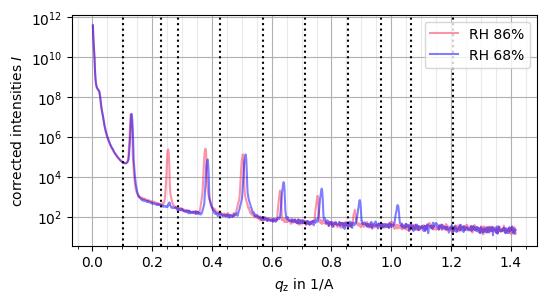

In [6]:
# plotting data (sanity check)
RH = 86
RH_R_corr = RH_data_dict[f"RH{RH}"]["R_corr"]
RH_angle = RH_data_dict[f"RH{RH}"]["angle"]
RH_q_z = RH_data_dict[f"RH{RH}"]["q_z"]

RH_2 = 68
RH_3 = 58


fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$q_\mathrm{z}$ in 1/A')             # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax.set_ylabel(r'corrected intensities $I$')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"RH {RH}%")
ax.semilogy(RH_data_dict[f"RH{RH_2}"]["q_z"], RH_data_dict[f"RH{RH_2}"]["R_corr"], color = "blue", alpha = 0.5, label = f"RH {RH_2}%")
# ax.semilogy(RH_data_dict[f"RH{RH_3}"]["q_z"], RH_data_dict[f"RH{RH_3}"]["R_corr"], color = "black", alpha = 0.5, label = f"RH {RH_3}%")


# indizes for vertical marks for period D determination
q_z_index_list = [70, 160, 200, 300, 400, 500, 600, 680, 750, 850]

# plot xvlines 
for q_z_index in q_z_index_list:
    q_z = RH_q_z[q_z_index]
    ax.axvline(x = q_z, linestyle = "dotted", color = "black")

ax.legend()
ax.legend(loc="upper right")

plt.savefig('BK.SLM_visualizations/corr_R_over_q_z.pdf', facecolor = 'white', bbox_inches='tight')
plt.show()

<>:50: SyntaxWarning: invalid escape sequence '\,'
<>:50: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_8823/966573158.py:50: SyntaxWarning: invalid escape sequence '\,'
  ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"$RH={RH}\,\%$")


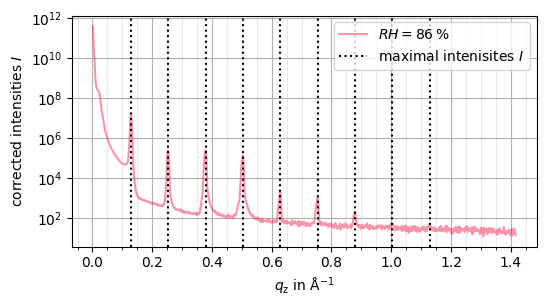

In [7]:
# +++++ DETERMINATION OF MAXIMA +++++

# function to return (max_value_index, max_value) for a given array and start, end index
def get_max(array, start_i, end_i):
    max_index = start_i
    max_value = array[start_i]
    for i in range(start_i, end_i):
        if array[i] > max_value:
            max_index = i
            max_value = array[i]
    return (max_index, max_value)


# iterate through the RH values
for key in RH_data_dict:
    RH_R_corr = RH_data_dict[key]["R_corr"]
    q_z_array = RH_data_dict[key]["q_z"]

    # iterate through the q_z index checkmarks
    max_q_z_list = []
    max_q_z_index_list = []
    for i in range(1, len(q_z_index_list)):
        q_z_start_index = q_z_index_list[i-1]
        q_z_end_index = q_z_index_list[i]

        max_q_z_index, max_value = get_max(RH_R_corr, q_z_start_index, q_z_end_index)
        max_q_z_list.append(q_z_array[max_q_z_index])
        max_q_z_index_list.append(max_q_z_index)
    
    # save list of indices, and q_z_values of maximum peak values
    RH_data_dict[key]["q_z_max"] = max_q_z_list                     # adds the list of Bragg peak q_z values to respective RH
    RH_data_dict[key]["q_z_index_max"] = max_q_z_index_list         # adds the list of Bragg peak q_z indices to respective RH


# sanity check for maximum determination
RH = 86
RH_R_corr = RH_data_dict[f"RH{RH}"]["R_corr"]
RH_angle = RH_data_dict[f"RH{RH}"]["angle"]
RH_q_z = RH_data_dict[f"RH{RH}"]["q_z"]
RH_max_q_z_list = RH_data_dict[f"RH{RH}"]["q_z_max"]


fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$q_\mathrm{z}$ in $\mathrm{\AA}^{-1}$')             # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!! also remove the mathdefaults
ax.set_ylabel(r'corrected intensities $I$')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"$RH={RH}\,\%$")

# plot xvlines at maxima
ax.axvline(x = RH_max_q_z_list[0], linestyle = "dotted", color = "black", label = r"maximal intenisites $I$")
for max_q_z in RH_max_q_z_list[1:]:
    ax.axvline(x = max_q_z, linestyle = "dotted", color = "black")

ax.legend()
ax.legend(loc="upper right")

plt.savefig('BK.SLM_visualizations/corr_R_over_q_z_q_z_max.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/corr_R_over_q_z_q_z_max.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()

In [8]:
# dropping shitty q_z maxima from the corresponding lists

# index 9 dropped from RH88
RH_data_dict[f"RH88"]["q_z_max"] = RH_data_dict[f"RH88"]["q_z_max"][:8]
RH_data_dict[f"RH88"]["q_z_index_max"] = RH_data_dict[f"RH88"]["q_z_index_max"][:8]
RH_data_dict[f"RH88"]["q_z_max"]


[0.12812565038309592,
 0.25195072959826637,
 0.37571771892849115,
 0.4993980825954388,
 0.6243828142920381,
 0.7478025893433815,
 0.8724654739236156,
 1.0280012221952777]

In [9]:
# +++++ DETERMINATION OF PERIOD LENGTH +++++

# calculates period D for given q_z
def get_D(q_z, n):
    return 2 * np.pi * n / q_z


# iterate through the RH values
for key in RH_data_dict:
    q_z_max_list = RH_data_dict[key]["q_z_max"]             # list of q_z maxima
    len_q_z_max_list = len(q_z_max_list)                    # len of the q_u maxima list
    D_list = []                                             # list of period lengths D (to be filled)
    # iterate through the maxima (excluding 1st and last)
    for i in range(1, len_q_z_max_list-1):
        q_z = q_z_max_list[i]
        D = get_D(q_z, i+1)                                 # calculate period length for each (maximum) q_z
        D_list.append(D)                                    # append D to D list
    RH_data_dict[key]["D_list"] = D_list
    RH_data_dict[key]["D"] = np.mean(D_list)
    RH_data_dict[key]["D_error"] = np.std(D_list)
    print(f"{key} D: mean: {np.mean(D_list)}, std: {np.std(D_list)},  {D_list}")

RH56 D: mean: 48.82075562154814, std: 0.15834946342402148,  [48.50651574872953, 48.6949500758583, 48.79876516712504, 48.87092586034388, 48.929222058217384, 48.98131517596409, 48.963595264598744]
RH58 D: mean: 48.82075562154814, std: 0.15834946342402148,  [48.50651574872953, 48.6949500758583, 48.79876516712504, 48.87092586034388, 48.929222058217384, 48.98131517596409, 48.963595264598744]
RH60 D: mean: 48.90365762416322, std: 0.16937655875427376,  [48.50651574872953, 48.87450148151844, 48.933762135700476, 48.97906247736787, 49.0193945562798, 48.98131517596409, 49.03105179358236]
RH62 D: mean: 48.96263707162222, std: 0.10367886331618498,  [48.77441765424902, 48.87450148151844, 48.933762135700476, 48.97906247736787, 49.0193945562798, 49.05862525153538, 49.09869594470448]
RH64 D: mean: 48.9723274366228, std: 0.11810861960532808,  [48.77441765424902, 48.87450148151844, 48.933762135700476, 48.97906247736787, 49.0193945562798, 49.05862525153538, 49.166528499708605]
RH66 D: mean: 49.01185325121

<>:40: SyntaxWarning: invalid escape sequence '\,'
<>:40: SyntaxWarning: invalid escape sequence '\,'
/tmp/ipykernel_8823/1029438813.py:40: SyntaxWarning: invalid escape sequence '\,'
  ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"$RH={RH}\,\%$")


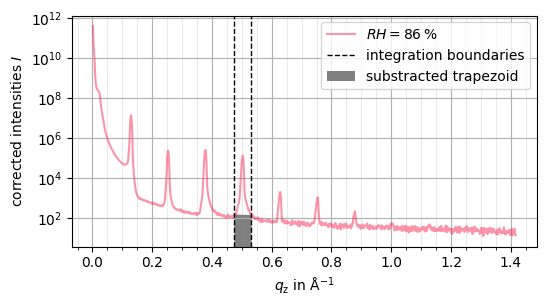


 +++++ NORMALIZED DATA +++++
RH56 |F(q_z^n)|: & 1.0 & 0.0922 & 0.1432 & 0.3979 & 0.107 & 0.0912 & 0.0548 & 0.0586 & 0.0194   Proportionality-Check: 2.4864611051754824
RH58 |F(q_z^n)|: & 0.9977 & 0.0777 & 0.1571 & 0.4014 & 0.1066 & 0.0916 & 0.0551 & 0.0591 & 0.0219   Proportionality-Check: 2.4864611051754824
RH60 |F(q_z^n)|: & 0.9961 & 0.0634 & 0.1712 & 0.405 & 0.107 & 0.0908 & 0.0549 & 0.057 & 0.0208   Proportionality-Check: 2.4864611051754832
RH62 |F(q_z^n)|: & 0.9928 & 0.0497 & 0.1851 & 0.4105 & 0.1093 & 0.0914 & 0.0558 & 0.0542 & 0.016   Proportionality-Check: 2.486461105175482
RH64 |F(q_z^n)|: & 0.99 & 0.0345 & 0.1987 & 0.4133 & 0.1079 & 0.0901 & 0.0542 & 0.0542 & 0.0177   Proportionality-Check: 2.486461105175483
RH66 |F(q_z^n)|: & 0.9858 & 0.0178 & 0.2158 & 0.4179 & 0.1088 & 0.0893 & 0.0541 & 0.0485 & 0.0132   Proportionality-Check: 2.4864611051754824
RH68 |F(q_z^n)|: & 0.9821 & 0.0073 & 0.2316 & 0.42 & 0.1073 & 0.0895 & 0.0535 & 0.0488 & 0.0   Proportionality-Check: 2.4864611051

In [10]:
# +++++ DETERMINATION OF FORM FACTOR SQUARE VALUES +++++

# function to calculate the integrated value below a given peak
def get_integrated_peak(R_corr_array, q_z_array, peak_i, plot = 0):
    num_intervals = 1                       # number of values summed up
    total_integral_sum = R_corr_array[peak_i]

    # sum values left of peak until turning point is reached
    d_i = 1
    while R_corr_array[peak_i - (d_i-1)] > R_corr_array[peak_i - d_i] or d_i < 5:
        # add values left and right of peak
        total_integral_sum += R_corr_array[peak_i - d_i] + R_corr_array[peak_i + d_i]
        num_intervals += 2
        d_i += 1

    # lower and upper q_z boundaries
    upper_q_z = q_z_array[peak_i + d_i]
    lower_q_z = q_z_array[peak_i - d_i]
    q_z_interval = upper_q_z - lower_q_z
    # lower and upper R values
    upper_R_corr = R_corr_array[peak_i + d_i]
    lower_R_corr = R_corr_array[peak_i - d_i]
    mid_R_corr = (upper_R_corr + lower_R_corr) / 2

    # total integral
    total_integral_sum *= q_z_interval / num_intervals
    # trapezoid subtraction value
    trapezoid_subtraction = mid_R_corr * q_z_interval


    # sanity check
    if plot:
        fig, ax = plt.subplots(figsize=(6,3))
        ax.set_xlabel(r'$q_\mathrm{z}$ in $\mathrm{\AA}^{-1}$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
        ax.set_ylabel(r'corrected intensities $I$')      
        ax.grid()
        ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
        ax.minorticks_on()

        ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"$RH={RH}\,\%$")

        # plot xvlines at integration boundaries
        ax.axvline(x = lower_q_z, linestyle = "dashed", color = "black", linewidth = 1, label = "integration boundaries")
        ax.axvline(x = upper_q_z, linestyle = "dashed", color = "black", linewidth = 1)

        # polygon for substracion
        polygon = Polygon(np.array([ [lower_q_z, 0], [lower_q_z, lower_R_corr], [upper_q_z, upper_R_corr], [upper_q_z, 0] ]), facecolor = "grey", label = "substracted trapezoid")
        ax.add_patch(polygon)

        ax.legend()
        ax.legend(loc="upper right")

        plt.savefig('BK.SLM_visualizations/corr_R_over_q_z_integrated_peak.pdf', facecolor = 'white', bbox_inches='tight')
        plt.savefig('BK.SLM_visualizations/corr_R_over_q_z_integrated_peak.pgf', facecolor = 'white', bbox_inches='tight')
        plt.show()

    return total_integral_sum - trapezoid_subtraction


# call the sanity check for the following parameters
RH_sanity_check = "RH86"
Bragg_n_sanity_check = 3


# iterate through the RH values
for key in RH_data_dict:
    R_corr_array = RH_data_dict[key]["R_corr"]
    q_z_array = RH_data_dict[key]["q_z"]
    max_q_z_index_list = RH_data_dict[key]["q_z_index_max"]
    D = RH_data_dict[key]["D"]
    form_factor_abs_list = []
    # iterate through all maxima
    for n, max_q_z_index in enumerate(max_q_z_index_list):
        # plot the integrated peak as a sanity check for above parameters
        if key == RH_sanity_check and n == Bragg_n_sanity_check:
            integrated_peak = get_integrated_peak(R_corr_array, q_z_array, max_q_z_index, plot = 1)
        else:
            integrated_peak = get_integrated_peak(R_corr_array, q_z_array, max_q_z_index, plot = 0)
        # calculate the absolute value for the form factor (order proportionality included)
        if integrated_peak < 0:
            form_factor_abs_list.append(0)
        else:
            form_factor_abs = np.sqrt(integrated_peak * (n+1)**2)
            # print(integrated_peak)
            form_factor_abs_list.append(form_factor_abs)
    # squared sum of all form factor amplitudes for normalization
    abs_F_q_z_n_normalization_squared_sum = sum([ff_abs**2 for ff_abs in form_factor_abs_list])
    RH_data_dict[key]["abs_F_q_z_n_normalization_squared_sum"] = abs_F_q_z_n_normalization_squared_sum
    # normalize form factor amplitudes to be proportional to period length D
    abs_F_q_z_n = [ff_abs * np.sqrt(D / abs_F_q_z_n_normalization_squared_sum) for ff_abs in form_factor_abs_list]
    RH_data_dict[key]["abs_F_q_z_n"] = abs_F_q_z_n
    # print(f"{key} |F(q_z^n)|: {form_factor_square_value_list}, norm_sum: {sum(form_factor_square_value_list)}")


# printing the normalized data (normalization abs_F_q_z_n**2 propto D done previously, here: normalization to 1 as biggest value)
print("\n +++++ NORMALIZED DATA +++++")
for key in RH_data_dict:
    normalized_abs_F_q_z_n_list = [ff_abs / RH_data_dict["RH56"]["abs_F_q_z_n"][0] for ff_abs in RH_data_dict[key]["abs_F_q_z_n"]]
    RH_data_dict[key]["abs_F_q_z_n_normalized"] = normalized_abs_F_q_z_n_list
    print(f"{key} |F(q_z^n)|:", end='')
    for normalized_abs_F_q_z_n in normalized_abs_F_q_z_n_list:
        print(f" & {round(normalized_abs_F_q_z_n, 4)}", end='')
    print(f"   Proportionality-Check: {sum([F_norm**2 for F_norm in normalized_abs_F_q_z_n_list]) / RH_data_dict[key]["D"] * 100}")

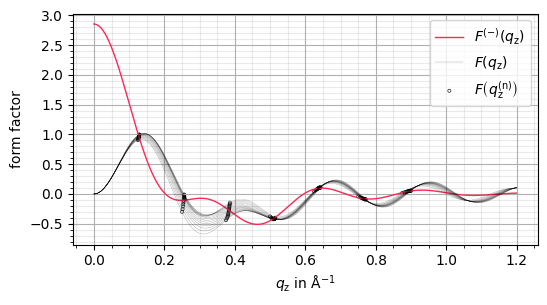

0.053724615220159616

In [11]:
# +++++ CONTINUOUS (MINUS FLUID) FORM FACTORS +++++

# number of Bragg maxima to be used for evaluation
max_n = 7                                  
       

# returns continuous minus fluid form factor function for given array with phases
def get_continuous_F_minus(phases):
    # continuous minus fluid form factor function
    def F_minus_continuous(q_z):
        F_minus_q_z_list = []
        # we average over all RH values we got
        for key in RH_data_dict:
            F_q_z_n_array =  RH_data_dict[key]["abs_F_q_z_n_normalized"]        # normalized form factor amplitudes for current RH
            D = RH_data_dict[key]["D"]                                          # period D for current RH
            F_minus_q_z = 0                                                     # initialization of fourier sum as F^(-)(q_z)
            F_minus_0 = 0                                                       # initialization of the order 0 F^(-)
            # iterate through the form factors until order max_n
            for i in range(max_n):
                nu_i = phases[i]                                                # phase i
                F_i = F_q_z_n_array[i]                                          # form factor amplitude i
                # calculate form factors for (n = -n_max till n = n_max excluding the order 0 term)
                F_minus_q_z += nu_i * F_i * ( np.sinc(D/2/np.pi*q_z - (i+1)) + np.sinc(D/2/np.pi*q_z + (i+1)) )
                # calculation the 0-order coefficient (with phase, how amazing is that ?)
                F_minus_0 += 2*(-1)**(i) * nu_i * F_i
            # add the order 0 term to fourier series
            F_minus_q_z += F_minus_0 * np.sinc(D/2/np.pi*q_z)
            # add the newest value to the list
            F_minus_q_z_list.append(F_minus_q_z)
        # return the average value between all RHs
        return sum(F_minus_q_z_list) / len(F_minus_q_z_list)
    return F_minus_continuous


# return continuous form factor function for a given RH key and given phases
def get_continuous_F(RH_key, phases):
    F_q_z_n_array =  RH_data_dict[RH_key]["abs_F_q_z_n_normalized"]             # normalized form factor amplitudes for current RH
    D = RH_data_dict[RH_key]["D"]                                               # period D for current RH
    # function of the continuous form factor reconstructed from its form factor amplitudes
    def F_continuous(q_z):
        F_q_z = 0                                                               # initialization of the fourier sum
        # iterate through the form factors until order max_n
        for i in range(max_n):
            nu_i = phases[i]                                                    # phase i
            F_i = F_q_z_n_array[i]                                              # form factor amplitude i
            # calculate form factors for (n = -n_max till n = n_max excluding the order 0 term)
            F_q_z += nu_i * F_i * ( np.sinc(D/2/np.pi*q_z - (i+1)) + np.sinc(D/2/np.pi*q_z + (i+1)) )
        return F_q_z
    return F_continuous


# function to check the performance of a given set of phase factors (the lower the better)
def phase_factor_performance(phases, plot = 0):
    F_minus_func = get_continuous_F_minus(phases)                               # get the analytical approximation of the continuous minus fluid form factor
    mean_squared_deviation_list = []
    # iterate over all RH values
    for key in RH_data_dict:
        # q_z_n_array = RH_data_dict[key]["q_z_max"]                            # q_z values for evaluation
        D = RH_data_dict[key]["D"]                                              # period D for current RH
        # iterate through n_max form factor amplitudes for each RH
        for i in range(max_n):
            F_func = get_continuous_F(key, phases)                              # get the analytical approximation of the continuous form factor
            # q_z = q_z_n_array[i]                                              # q_z value to be evaluated
            q_z = 2*np.pi/D * (i+1)                                             # q_z value to be evaluated
            F_minus_analytical = F_minus_func(q_z)                              # evaluation of the continuous minus fluid form factor at q_z
            F_analytical = F_func(q_z)                                          # evaluation of the continuous form factor at q_z
            # add the MSD for each evaluated position to the list
            mean_squared_deviation_list.append((F_minus_analytical - F_analytical)**2)

    # plot certain continuous form factor reconstructions alongside the minus fluid model 
    if plot == 1:
        q_z_conti_array = np.linspace(0, 1.2, 1000)
        F_minus_array = np.array([F_minus_func(q_z) for q_z in q_z_conti_array])

        fig, ax = plt.subplots(figsize=(6,3))
        ax.set_xlabel(r'$q_\mathrm{z}$ in $\mathrm{\AA}^{-1}$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
        ax.set_ylabel(r'form factor')      
        ax.grid()
        ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
        ax.minorticks_on()

        # continuous minus fluid form factor reconstruction
        ax.plot(q_z_conti_array, F_minus_array, color = "xkcd:red pink", alpha = 1, linewidth = 1, label = r"$F^{(-)}(q_\mathrm{z})$")

        # continuous form factor reconstructions
        F_RH88_func = get_continuous_F("RH88", phases)
        F_RH88_array = np.array([F_RH88_func(q_z) for q_z in q_z_conti_array])
        ax.plot(q_z_conti_array, F_RH88_array, color = "black", alpha = 0.88/2, linewidth = 0.25, label = r"$F(q_\mathrm{z})$")
        # evaluated q_z_n
        D = RH_data_dict["RH88"]["D"]                                           # period D for current RH
        q_z_n_plot_list = []                                                    # q_z_n values for plotting
        F_q_z_n_plot_list = []                                                  # corresponding F_q_z_n values for plotting
        for i in range(max_n):
            # values for plotting
            q_z_n = 2*np.pi/D * (i+1)                                           # q_z_n from period length
            F_q_z_n = F_RH88_func(q_z_n)                                        # corresponding F_q_z_n
            # add values for plotting to plot list
            q_z_n_plot_list.append(q_z_n)      
            F_q_z_n_plot_list.append(F_q_z_n)                                            
        ax.scatter(q_z_n_plot_list, F_q_z_n_plot_list, s = 5, marker = "o", edgecolor = "black", facecolor = "none", alpha = 0.88, linewidth = 0.5, label = r"$F\left(q_\mathrm{z}^\mathrm{(n)}\right)$")

        for RH in range(56, 87, 2):
            # continuous form factor reconstructions
            F_RH_func = get_continuous_F(f"RH{RH}", phases)
            F_RH_array = np.array([F_RH_func(q_z) for q_z in q_z_conti_array])
            ax.plot(q_z_conti_array, F_RH_array, color = "black", alpha = RH/100/2, linewidth = 0.25)
            # evaluated q_z_n
            D = RH_data_dict[f"RH{RH}"]["D"]                                    # period D for current RH
            q_z_n_plot_list = []                                                # q_z_n values for plotting
            F_q_z_n_plot_list = []                                              # corresponding F_q_z_n values for plotting
            for i in range(max_n):
                # values for plotting
                q_z_n = 2*np.pi/D * (i+1)                                       # q_z_n from period length
                F_q_z_n = F_RH_func(q_z_n)                                      # corresponding F_q_z_n
                # add values for plotting to plot list
                q_z_n_plot_list.append(q_z_n)      
                F_q_z_n_plot_list.append(F_q_z_n)                                            
            ax.scatter(q_z_n_plot_list, F_q_z_n_plot_list, s = 5, marker = "o", edgecolor = "black", facecolor = "none", alpha = RH/100, linewidth = 0.5)

        # ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        # ax.set_yticklabels(["-1", "", "0", "", "1"]) 
        ax.legend()
        ax.legend(loc="upper right")

        plt.savefig('BK.SLM_visualizations/continuous_form_factors.pdf', facecolor = 'white', bbox_inches='tight')
        plt.savefig('BK.SLM_visualizations/continuous_form_factors.pgf', facecolor = 'white', bbox_inches='tight')
        plt.show()

    # return the RMSD for the given phases
    return np.sqrt(sum(mean_squared_deviation_list) / len(mean_squared_deviation_list))


# list of phases (0-order will be determined from the other phases, genius !!!)
phases_list = [+1, -1, -1, -1, +1, -1, +1]                                       # fail orders: 1, 3

# phases_list =  [-1, -1, +1, -1, +1, -1, +1]
phase_factor_performance(phases_list, plot = 1)

In [12]:
# +++++ GENERATE ALL COMBINATIONS OF PHASE FACTORS AND EVALUATE THEIR FIT +++++

# array of all different phase combinations (n = n_max = 7) phase factors
n_max = 7
phase_factor_list = []               # array with all phase factor arrays (i.e. 2**n_max entries)
# iterate through all 2**n_max combinations
for i_factor in range(2**n_max):
    phase_factor_i_array = np.zeros((n_max))                # array with the 8 phase factors
    # iterate through each 7 phase factor positions
    for i in range(n_max):
        phase_factor_i_array[i] = (int(i_factor / 2**i )  % 2) * 2 - 1
    # add array of phase factors to the total array (only consider arrays with nu_1 = 1 due to symmetry)
    if phase_factor_i_array[0] < 0:
        phase_factor_list.append(phase_factor_i_array)


# iterate through all possible phase combinations
rmsd_list = []
for phase_factors in phase_factor_list:
    dict = {}
    rmsd = phase_factor_performance(phase_factors)
    dict["phase_factors"] = phase_factors
    dict["RMSD"] = rmsd
    rmsd_list.append(dict)

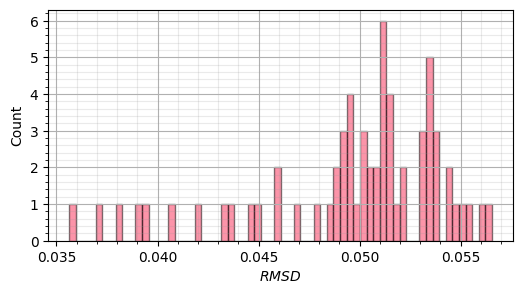

In [13]:
# +++++ HISTOGRAM OF RMSD VALUES +++++

plt.hist

fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$RMSD$') 
ax.set_ylabel(r'Count')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.hist([element["RMSD"] for element in rmsd_list], bins = 64, color = "xkcd:red pink", alpha = 0.5, edgecolor = "black")

plt.savefig('BK.SLM_visualizations/RMSD_histogram.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/RMSD_histogram.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()

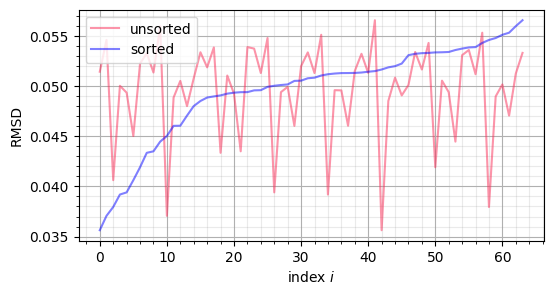

\textbf{1} & 0.0356 & $--+-+-+$ \\
\textbf{2} & 0.0371 & $--+-+--$ \\
\textbf{3} & 0.0379 & $--+-+++$ \\
\textbf{4} & 0.0392 & $--+---+$ \\
\textbf{5} & 0.0394 & $--+-++-$ \\
\textbf{6} & 0.0406 & $--+----$ \\
\textbf{7} & 0.0419 & $--+--++$ \\
\textbf{8} & 0.0433 & $--+--+-$ \\
\textbf{9} & 0.0435 & $-+-+-+-$ \\
\textbf{10} & 0.0445 & $-+-+-++$ \\
\textbf{11} & 0.045 & $-+-+---$ \\
\textbf{12} & 0.046 & $-+-+++-$ \\
\textbf{13} & 0.046 & $-+-+--+$ \\
\textbf{14} & 0.047 & $-+-++++$ \\
\textbf{15} & 0.048 & $-+-++--$ \\
\textbf{16} & 0.0485 & $-++-+-+$ \\
\textbf{17} & 0.0489 & $-++-+--$ \\
\textbf{18} & 0.049 & $-++-+++$ \\
\textbf{19} & 0.0491 & $-+-++-+$ \\
\textbf{20} & 0.0492 & $---+-+-$ \\
\textbf{21} & 0.0493 & $---+---$ \\
\textbf{22} & 0.0494 & $---+-++$ \\
\textbf{23} & 0.0494 & $-++-++-$ \\
\textbf{24} & 0.0496 & $---+--+$ \\
\textbf{25} & 0.0496 & $-++---+$ \\


In [14]:
# +++++ DETERMINATION OF THE BEST PHASE SETTING +++++

# recursively sort a list of dictionaries by a given key
def sort_dict_list(list, key):
    len_list = len(list)                                    # length of the list
    # end of sort
    if len_list <= 1:
        return list
    # find the smallest dict["key"] in the list and places it at index 0
    else:
        min_index = 0                                       # temp: minimum index
        min_key = list[0][key]                              # temp: minimum key
        # iterate through list
        for i in range(len_list):
            # set new minimum index and key if current key smaller than temp minimum key
            if list[i][key] < min_key:
                min_index = i
                min_key = list[i][key]
        # switch positions of minumum key element and element 0
        list[0], list[min_index] = list[min_index], list[0]
        # call the function recursively by omitting the lowest entry now at index 0
        return [list[0]] + sort_dict_list(list[1:], key) 


# find best fit with index
rmsd_list_unsorted = rmsd_list.copy()
rmsd_list_sorted = sort_dict_list(rmsd_list, "RMSD")


# sanity check for sorting the list
fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'index $i$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax.set_ylabel(r'RMSD')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.plot([i for i in range(len(rmsd_list_unsorted))], [element["RMSD"] for element in rmsd_list_unsorted], color = "xkcd:red pink", alpha = 0.5, label = f"unsorted")
ax.plot([i for i in range(len(rmsd_list_sorted))], [element["RMSD"] for element in rmsd_list_sorted], color = "blue", alpha = 0.5, label = f"sorted")

ax.legend()
ax.legend(loc="upper left")

plt.savefig('BK.SLM_visualizations/RMSD_sorted.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/RMSD_sorted.pgf', facecolor = 'white', bbox_inches='tight')

plt.show()


# printing the bset 10 phase combinations
for i in range(25):
    rmsd, phase_factors = rmsd_list_sorted[i]["RMSD"], rmsd_list_sorted[i]["phase_factors"]
    # print(f"{i:>3}. RMSD: {round(rmsd, 4)}\t {phase_factors}")
    phase_factors_string = ""
    for phase_factor in phase_factors:
        if phase_factor > 0:
            phase_factors_string += "+"
        else:
            phase_factors_string += "-"
    print(f"\\textbf{ {i+1} } & {round(rmsd, 4)} & ${phase_factors_string}$ \\\\")


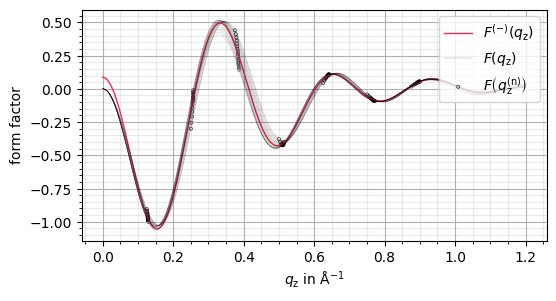

0.03563426016034545

In [15]:
# +++++ APPLYING BEST FIT +++++

# plotting the best phase combination (eye test suggests #2)
phase_factors_best_fit = rmsd_list_sorted[0]["phase_factors"]

# manual configuration
# phase_factors_best_fit = [-1, -1, +1, -1, 1, -1, 1]
phase_factor_performance(phase_factors_best_fit, plot = 1)

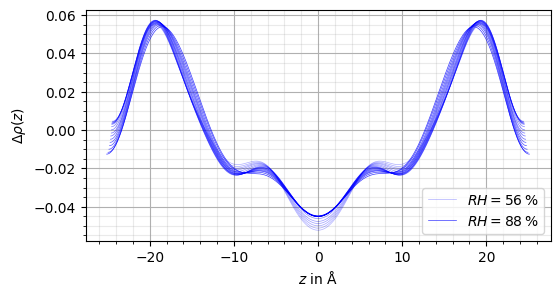

In [16]:
# +++++ e-DENSITY DETERMINATION +++++

# reconstruct the function for the electron density for a given RH and phases 
def get_rho_continuous(RH_key, phases):
    D = RH_data_dict[RH_key]["D"]                                                   # period D for current RH
    abs_F_q_z_n_normalized = RH_data_dict[RH_key]["abs_F_q_z_n_normalized"]            # form factor amplitudes
    # electron density function
    def rho_continuous(z):
        rho_sum = 0
        # iterate through the discrete form factor amplitudes
        for i in range(max_n):
            # values for plotting
            q_z_n = 2*np.pi/D * (i+1)                                                   # q_z_n from period length
            
            rho_sum += abs_F_q_z_n_normalized[i]*phases[i] * np.cos(q_z_n * z)
        return 2/D*rho_sum
    return rho_continuous


# plot the electron desities for each RH
fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$z$ in $\mathrm{\AA}$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax.set_ylabel(r'$\Delta\rho\left(z\right)$')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()


# electron density profile plots RH60 and RH 92 for legend
D_RH56 = RH_data_dict["RH56"]["D"]
D_RH88 = RH_data_dict["RH88"]["D"]
z_RH56_array = np.linspace(-D_RH56/2, D_RH56/2, 1000)
z_RH88_array = np.linspace(-D_RH88/2, D_RH88/2, 1000)
rho_RH56_func = get_rho_continuous("RH56", phase_factors_best_fit)
rho_RH88_func = get_rho_continuous("RH88", phase_factors_best_fit)
rho_RH56_array = np.array([rho_RH56_func(z) for z in z_RH56_array])
rho_RH88_array = np.array([rho_RH88_func(z) for z in z_RH88_array])
ax.plot(z_RH56_array, rho_RH56_array, color = "blue", alpha = (56 / 100)**2, linewidth = 0.5, label = r"$RH=56\,\%$")
ax.plot(z_RH88_array, rho_RH88_array, color = "blue", alpha = (88 / 100)**2, linewidth = 0.5, label = r"$RH=88\,\%$")

# iterate through the RH values to receive other electron density profiles
for RH in range(58, 87, 2):
    rho_func = get_rho_continuous(f"RH{RH}", phase_factors_best_fit)
    D = RH_data_dict[f"RH{RH}"]["D"]
    z_array = np.linspace(-D/2, D/2, 1000)
    rho_array = np.array([rho_func(z) for z in z_array])
    ax.plot(z_array, rho_array, color = "blue", alpha = (RH / 100)**2, linewidth = 0.5)

# ax.set_yticks([0, 0.02, 0.04, -0.02, -0.04, 0.06])
# ax.set_yticklabels(["0", "", "", "", "", ""]) 
ax.legend()
ax.legend(loc="lower right")

plt.savefig('BK.SLM_visualizations/electron_density.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/electron_density.pgf', facecolor = 'white', bbox_inches='tight')

plt.show()

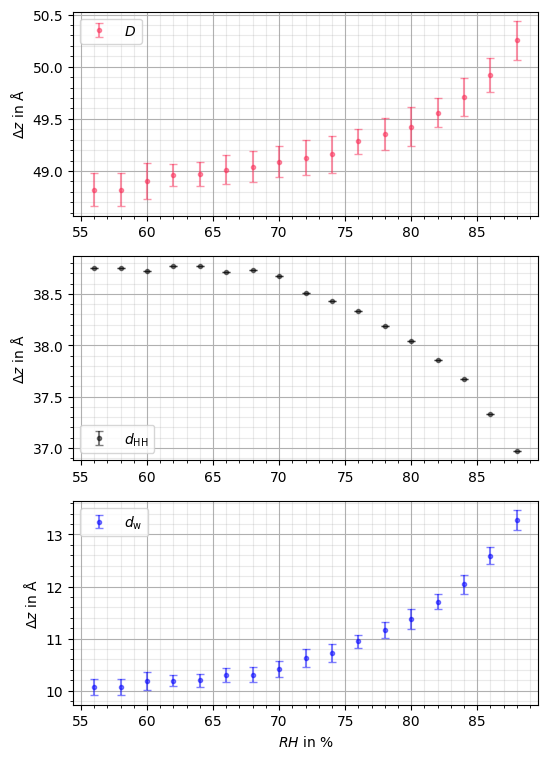

In [17]:
# +++++ EVALUATION OF THE MEMBRANE STRUCTURE +++++


RH_plot_list = []                                   # relative humidity RH plot list
D_plot_list = []                                    # period D plot list
d_HH_plot_list = []                                 # distance of head group distance d_HH plot list
d_w_plot_list = []                                  # width of water d_w layer plot list
D_error_plot_list = []                              # errors of the period D
d_HH_error_plot_list = []                           # errors of head group distance d_HH
d_w_error_plot_list = []                            # errors of water d_w layer
# uniform errors of d_HH
d_HH_error = 0
# filling the above lists for each RH
for RH in range(56, 89, 2):
    D = RH_data_dict[f"RH{RH}"]["D"]                # period D for each RH
    D_error = RH_data_dict[f"RH{RH}"]["D_error"]                # period D for each RH
    # calculate z-coordinate of minus / plus head groups
    rho_func = get_rho_continuous(f"RH{RH}", phase_factors_best_fit)
    z_array = np.linspace(-D/2, D/2, 1000)
    rho_array = np.array([rho_func(z) for z in z_array])
    # left density maximum
    head_minus_index = 0
    head_minus = rho_array[head_minus_index]
    for i in range(490):
        if rho_array[i] > head_minus:
            head_minus_index = i
            head_minus = rho_array[i]
    # right density maximum
    head_plus_index = 500
    head_plus = rho_array[head_plus_index]
    for i in range(head_plus_index, head_plus_index+490):
        if rho_array[i] > head_plus:
            head_plus_index = i
            head_plus = rho_array[i]
    d_HH = z_array[head_plus_index] - z_array[head_minus_index]                   # distance of head groups d_HH
    d_w = D - d_HH                                  # width of water layer d_w

    # append values to plot lists
    RH_plot_list.append(RH)
    D_plot_list.append(D)
    d_HH_plot_list.append(d_HH)
    d_w_plot_list.append(d_w)
    # append errors to plot lists
    D_error_plot_list.append(D_error)
    d_w_error_plot_list.append(D_error - d_HH_error)
    

# visualization of the membran parameters over R
fig, ax = plt.subplots(3, figsize=(6,9))
# ax[0].set_xlabel(r'$RH$ in $\%$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax[0].set_ylabel(r'$\Delta z$ in $\mathrm{\AA}$')      
ax[0].grid()
ax[0].grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax[0].minorticks_on()

# ax[0].scatter(RH_plot_list, D_plot_list, color = "xkcd:red pink", alpha = 0.5, label = r"$D$")
ax[0].errorbar(RH_plot_list, D_plot_list, yerr = D_error_plot_list, fmt = '.', color = "xkcd:red pink", alpha = 0.5, ecolor = "xkcd:red pink", capsize = 3, label = r"$D$")
# ax[0].plot(RH_plot_list, d_HH_plot_list, color = "black", alpha = 0.5, label = r"$d_\mathrm{HH}$")
# ax[0].plot(RH_plot_list, d_w_plot_list, color = "blue", alpha = 0.5, label = r"$d_\mathrm{w}$")

# plot xvlines at integration boundaries
ax[0].legend()
ax[0].legend(loc="upper left")


# ax[1].set_xlabel(r'$RH$ in $\%$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax[1].set_ylabel(r'$\Delta z$ in $\mathrm{\AA}$')      
ax[1].grid()
ax[1].grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax[1].minorticks_on()

# ax[1].plot(RH_plot_list, D_plot_list, color = "xkcd:red pink", alpha = 0.5, label = r"$D$")
ax[1].errorbar(RH_plot_list, d_HH_plot_list, yerr = d_HH_error, fmt = '.', color = "black", alpha = 0.5, ecolor = "black", capsize = 3, label = r"$d_\mathrm{HH}$")
# ax[1].plot(RH_plot_list, d_w_plot_list, color = "blue", alpha = 0.5, label = r"$d_\mathrm{w}$")

# plot xvlines at integration boundaries
ax[1].legend()
ax[1].legend(loc="lower left")


ax[2].set_xlabel(r'$RH$ in $\%$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax[2].set_ylabel(r'$\Delta z$ in $\mathrm{\AA}$')      
ax[2].grid()
ax[2].grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax[2].minorticks_on()

# ax[2].plot(RH_plot_list, D_plot_list, color = "xkcd:red pink", alpha = 0.5, label = r"$D$")
# ax[2].plot(RH_plot_list, d_HH_plot_list, color = "black", alpha = 0.5, label = r"$d_\mathrm{HH}$")
ax[2].errorbar(RH_plot_list, d_w_plot_list, yerr = d_w_error_plot_list, fmt = ".", color = "blue", alpha = 0.5, ecolor = "blue", capsize = 3, label = r"$d_\mathrm{w}$")

# plot xvlines at integration boundaries
ax[2].legend()
ax[2].legend(loc="upper left")

plt.savefig('BK.SLM_visualizations/membrane_structure_over_RH.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/membrane_structure_over_RH.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()